## **Modelo de segmentación de clientes**

### El objetivo es identificar patrones y similitudes entre los clientes para comprender mejor sus necesidades, comportamientos y preferencias

### Importemos las librerías que se usarán

In [1370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Ignorar todos los warnings
warnings.filterwarnings("ignore")

### Usaremos las tablas resultantes del EDA, así que las cargaremos

In [1371]:
clientes = pd.read_csv("tabla_clientes_limpia.csv")
transacciones = pd.read_csv("tabla_transacciones_limpia.csv")

### Uniremos los dos dataframes para trabajar con toda la información en cojunto

In [1372]:
df_modelo = pd.merge(clientes, transacciones, on = "Id")
df_modelo.head().T

,0,1,2,3,4
Id,6,13,30,31,1888
TipoID_x,CE,CE,CE,CE,CC
Ocupacion,Ama de Casa,Ama de Casa,Ama de Casa,Ama de Casa,Ama de Casa
Nacimiento,1933-01-02,1930-04-20,1935-11-12,1932-06-04,1927-12-08
Edad,90,93,87,91,95
RangoEtario,Mayor de 50,Mayor de 50,Mayor de 50,Mayor de 50,Mayor de 50
Estado,Activo,Activo,Activo,Activo,Activo
IngresosFinancieros,30000000,755887000,18933000,8400000,21099000
Activos,532130000,886035000,431167000,152000000,508712000
Pasivos,"2,200,000.00","201,145,000.00",0.00,0.00,"45,094,000.00"


### Podemos notar que la variable "TipoID" se duplicó. Verifiquemos que sean iguales, y en caso de serlo, usaremos solo una

In [1373]:
son_iguales = df_modelo["TipoID_x"].equals(df_modelo["TipoID_y"])
if son_iguales is True:
    df_modelo.drop(columns = "TipoID_y", inplace = True)
    df_modelo.rename(columns = {"TipoID_x" : "Tipo_ID"}, inplace = True)
    print("Las columnas TipoID son iguales")
else: print("Las columnas TipoID son distintas")

Las columnas TipoID son iguales


In [1374]:
print(f"La tabla que se usará para el modelo tiene {df_modelo.shape[0]} registros y {df_modelo.shape[1]} variables")

La tabla que se usará para el modelo tiene 8189 registros y 22 variables


### Comencemos a implementar los modelos de ML. Para esto probaremos 2 algoritmos diferentes, calcularemos su eficacia, y nos quedaremos con el más óptimo

### Primero implementaremos un algoritmo de análisis de componentes principales (PCA) + K-means. Para esto, usaremos la técnica one-hot encoding con las variables categóricas y normalizaremos las variables numéricas

### Importemos las librerías necesarias

In [1375]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Creemos una copia del dataframe para el algoritmo k-means

In [1376]:
df_k_means = df_modelo.copy()

###  Este código realiza una preparación de los datos numéricos, aplicando una transformación logarítmica y luego busca el mejor número de componentes principales para el análisis de PCA utilizando validación cruzada. El objetivo es encontrar la mejor configuración de componentes principales para el análisis de clustering posterior

In [1377]:
# Separar las variables numéricas en un DataFrame
numeric_cols = df_k_means.select_dtypes(include = ["int", "float"]).columns.tolist()
# Removemos las variables que no se tendrán en cuenta producto del EDA
numeric_cols.remove("Id")
numeric_cols.remove("Edad")
numeric_cols.remove("Patrimonio")
numeric_cols.remove("RiesgoOcupacion")
numeric_cols.remove("Entradas_Frecuencia")
numeric_cols.remove("Salidas_Frecuencia")
df_numeric = df_k_means[numeric_cols]
# Aplicar la transformación logarítmica a las variables numéricas sin valores cero o negativos
df_numeric_transformed = df_numeric.apply(lambda x: np.log1p(x) if (x > 0).all() else x)
# Crear el estimador de PCA dentro de un Pipeline con la etapa de transformación logarítmica
pipeline = Pipeline([
    ("pca", PCA())
])
# Definir la grilla de hiperparámetros a explorar
param_grid = {
    "pca__n_components": [2, 3, 4, 5]
}
# Realizar la búsqueda de hiperparámetros utilizando validación cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv = 5)
grid_search.fit(df_numeric_transformed)
# Obtener el mejor valor de hiperparámetro
best_n_components = grid_search.best_params_["pca__n_components"]
# Mostrar el mejor valor de hiperparámetro
print("Mejor número de componentes principales:", best_n_components)

Mejor número de componentes principales: 2


###  Este código aplica una transformación logarítmica a los datos numéricos, realiza una búsqueda de hiperparámetros para encontrar el mejor número de clusters utilizando K-means y muestra el mejor valor encontrado

In [1378]:
# Aplicar la transformación logarítmica a las variables numéricas
df_numeric_transformed = np.log1p(df_numeric)
# Reemplazar los valores NaN generados por la transformación con ceros
df_numeric_transformed = np.nan_to_num(df_numeric_transformed, nan = 0.0)
# Aplicar la transformación logarítmica a los valores transformados
df_numeric_log = np.log(df_numeric_transformed + 1)  # Se suma 1 para evitar log(0)
# Definir la grilla de hiperparámetros a explorar
param_grid = {
    "n_clusters": [2, 3, 4, 5]
}
# Crear el estimador de K-means
kmeans = KMeans()
# Realizar la búsqueda de hiperparámetros utilizando validación cruzada
grid_search = GridSearchCV(kmeans, param_grid, cv = 5)
grid_search.fit(df_numeric_transformed)
# Obtener el mejor valor de hiperparámetro
best_n_clusters_kmeans = grid_search.best_params_["n_clusters"]
# Mostrar el mejor valor de hiperparámetro
print("Mejor número de clusters:", best_n_clusters_kmeans)

Mejor número de clusters: 5


### Este código realiza la transformación de las variables categóricas utilizando one-hot encoding, combina los datos numéricos transformados con los datos categóricos codificados, realiza PCA sobre los datos combinados y aplica K-means a las componentes principales resultantes para asignar etiquetas de segmentos al DataFrame original, esto, utlizando los hiperparámetros más óptimos calculados anteriormente

In [1379]:
# Separar las variables categóricas 
# Usaremos la variable ocupación como categorías
df_k_means["RiesgoOcupacion"] = df_k_means["RiesgoOcupacion"].astype(object)
categoric_cols = df_k_means.select_dtypes(include = ["object"]).columns.tolist()
# Removemos las variables que no se tendrán en cuenta producto del EDA 
categoric_cols.remove("Nacimiento")
df_categorical = df_k_means[categoric_cols]
# Aplicar one-hot encoding a las variables categóricas
encoder = OneHotEncoder(sparse = False, drop = "first")
df_categorical_encoded = encoder.fit_transform(df_categorical)
# Concatenar los datos numéricos normalizados y los datos categóricos codificados
df_combined = pd.concat([pd.DataFrame(df_numeric_log), pd.DataFrame(df_categorical_encoded)], axis=1)
# Aplicar PCA a los datos combinados
pca = PCA(best_n_components)
components = pca.fit_transform(df_combined)
# Aplicar K-means a los datos resultantes
kmeans = KMeans(best_n_clusters_kmeans, random_state = 42)
kmeans.fit(components)
# Obtener las etiquetas de los segmentos
segment_labels = kmeans.labels_
# Asignar las etiquetas de segmentos al DataFrame original
df_k_means["Cluster"] = segment_labels
# Mostrar cantidad de registros por cluster
df_cluster_kmeans = pd.DataFrame(df_k_means["Cluster"].value_counts()).reset_index()
df_cluster_kmeans.columns = ["Cluster", "Cantidad_Registros"]
df_cluster_kmeans

,Cluster,Cantidad_Registros
0,1,2204
1,0,2142
2,2,1667
3,3,1346
4,4,830


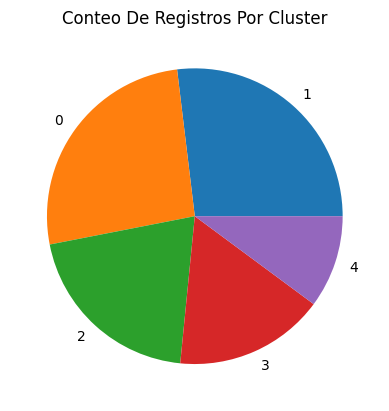

In [1380]:
plt.pie(data = df_cluster_kmeans, x = "Cantidad_Registros", labels = "Cluster")
plt.title("Conteo De Registros Por Cluster")
plt.show()

### Ahora evaluemos la calidad del algoritmo

In [1381]:
# Calcular la métrica de WCSS (suma de las distancias cuadradas dentro del cluster)
wcss_k_means = kmeans.inertia_
# Calcular la métrica de la silueta
labels = kmeans.labels_
silhouette_k_means = silhouette_score(components, labels)
print("WCSS:", wcss_k_means)
print("Silhouette Score:", silhouette_k_means)

WCSS: 3988.4364508808994
Silhouette Score: 0.604440072718845


### Ahora implementaremos un algoritmo de análisis de componentes principales (PCA) + Agglomerative Hierarchical Clustering. También usaremos la técnica one-hot encoding con las variables categóricas y normalizaremos las variables numéricas
### Creemos una copia del dataframe para el algoritmo Agglomerative Hierarchical Clustering

In [1382]:
df_Hierarchical = df_modelo.copy()

### Importar las librerías necesarias

In [1383]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist

### Este código busca encontrar el número óptimo de clusters utilizando Agglomerative Hierarchical Clustering y el coeficiente de silueta como métrica de evaluación

In [1384]:
best_n_clusters_hierarchical = None
best_silhouette = -1
for n_clusters in param_grid["n_clusters"]:
    # Crear el estimador de Agglomerative Hierarchical Clustering con la configuración actual
    ahc = AgglomerativeClustering(n_clusters=n_clusters)
    # Ajustar el modelo a los datos transformados
    labels = ahc.fit_predict(df_numeric_transformed)
    # Calcular el coeficiente de silueta
    silhouette = silhouette_score(df_numeric_transformed, labels)
    # Actualizar el mejor coeficiente de silueta y el mejor número de clusters
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_n_clusters_hierarchical = n_clusters
# Mostrar el mejor valor de hiperparámetro y el coeficiente de silueta correspondiente
print("Mejor número de clusters:", best_n_clusters_hierarchical)
print("Silhouette Score:", best_silhouette)

Mejor número de clusters: 4
Silhouette Score: 0.2606224489487138


### Este código realiza la preparación de los datos categóricos, aplica one-hot encoding, combina los datos numéricos y categóricos codificados, realiza la reducción de dimensionalidad con PCA, aplica Agglomerative Hierarchical Clustering y asigna las etiquetas de los clusters al DataFrame original. Finalmente, muestra la cantidad de registros por cluster
### Es importante aclarar que usa el mismo valor óptimo de componentes principales (PCA) calculado anteriromente para el algoritmo K-means

In [1385]:
# Separar las variables categóricas
# Usaremos la variable ocupación como categorías
df_Hierarchical["RiesgoOcupacion"] = df_Hierarchical["RiesgoOcupacion"].astype(object)
categoric_cols = df_Hierarchical.select_dtypes(include=["object"]).columns.tolist()
# Removemos las variables que no se tendrán en cuenta producto del EDA
categoric_cols.remove("Nacimiento")
df_categorical = df_Hierarchical[categoric_cols]
# Aplicar one-hot encoding a las variables categóricas
encoder = OneHotEncoder(sparse = False, drop = "first")
df_categorical_encoded = encoder.fit_transform(df_categorical)
# Concatenar los datos numéricos normalizados y los datos categóricos codificados
df_combined = pd.concat([pd.DataFrame(df_numeric_log), pd.DataFrame(df_categorical_encoded)], axis=1)
# Aplicar PCA a los datos combinados
pca = PCA(n_components = best_n_components)
components = pca.fit_transform(df_combined)
# Crear el estimador de Agglomerative Hierarchical Clustering
ahc = AgglomerativeClustering(n_clusters = best_n_clusters_hierarchical)
# Realizar el clustering
ahc.fit(components)
# Obtener las etiquetas de los segmentos
segment_labels = ahc.labels_
# Asignar las etiquetas de segmentos al DataFrame original
df_Hierarchical["Cluster"] = segment_labels
# Mostrar cantidad de registros por cluster
df_cluster_ahc = pd.DataFrame(df_Hierarchical["Cluster"].value_counts()).reset_index()
df_cluster_ahc.columns = ["Cluster", "Cantidad_Registros"]
df_cluster_ahc

,Cluster,Cantidad_Registros
0,0,3115
1,2,2288
2,1,1575
3,3,1211


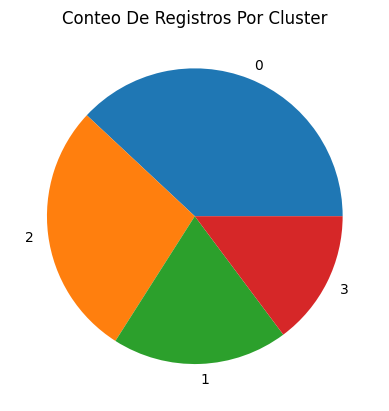

In [1386]:
plt.pie(data = df_cluster_ahc, x = "Cantidad_Registros", labels = "Cluster")
plt.title("Conteo De Registros Por Cluster")
plt.show()

### Pasemos a evaluar la calidad de algoritmo

In [1387]:
# Calcular las distancias entre los datos y los centroides
distances = pdist(df_Hierarchical[numeric_cols], metric = "euclidean")
# Calcular WCSS sumando las distancias al cuadrado
wcss_hierarchical = (distances ** 2).sum()
# Calcular Silhouette Score
silhouette_hierarchical = silhouette_score(components, df_Hierarchical["Cluster"])
# Mostrar los resultados
print("WCSS:", wcss_hierarchical)
print("Silhouette Score:", silhouette_hierarchical)

WCSS: 5.409540992186964e+28
Silhouette Score: 0.6229270837526371


### Ahora que tenemos nuestros algoritmos testeados, averiguemos cual es más eficiente

### Primero veamos una resumida definición de las métricas de calidad usadas:

- WCSS (Within-Cluster Sum of Squares): El WCSS es una medida de la varianza dentro de cada cluster. Cuanto menor sea el valor de WCSS, mejor será la agrupación, ya que indica que los puntos dentro de cada cluster están más cercanos entre sí.

- Silhouette Score: El Silhouette Score es una medida de la cohesión y separación de los clusters. Toma valores en el rango [-1, 1], donde un valor más cercano a 1 indica que los puntos dentro de un cluster están bien agrupados y separados de otros clusters. 

### Conclusión:

In [1388]:
print("Los resultados de la calidad del algoritmo K-Means son:")
print(f"- WCSS: {wcss_k_means}\n- Silhouette Score: {silhouette_k_means}\n")
print("Los resultados de la calidad del algoritmo Agglomerative Hierarchical Clustering son:")
print(f"- WCSS: {wcss_hierarchical}\n- Silhouette Score: {silhouette_hierarchical}")

Los resultados de la calidad del algoritmo K-Means son:
- WCSS: 3988.4364508808994
- Silhouette Score: 0.604440072718845

Los resultados de la calidad del algoritmo Agglomerative Hierarchical Clustering son:
- WCSS: 5.409540992186964e+28
- Silhouette Score: 0.6229270837526371


### Entre los dos valores mencionados, el primero es mejor en términos de calidad de clustering
### Comparando los valores de WCSS, el primer resultado tiene un valor mucho más bajo en comparación con el segundo resultado. Un valor de WCSS más bajo indica una mejor cohesión dentro de los clústeres, lo que significa que los puntos dentro de cada clúster están más cerca entre sí
### En cuanto al Silhouette Score, el segundo resultado es ligeramente mejor que el primero. Aunque la diferencia en los valores de Silhouette Score no es significativa, el segundo resultado tiene un valor ligeramente más alto, lo que implica una mejor calidad de clustering en términos de separación y cohesión
### En resumen, considerando tanto el WCSS como el Silhouette Score, el primer resultado es mejor que el segundo resultado en términos de calidad de clustering
### Esto indica que el análisis de componentes principales (PCA) y el algoritmo de clustering (K-means) han funcionado de manera efectiva en este conjunto de datos, por lo que crearemos los perfiles de cluster a partir de sus resultados

### Etiquetaremos los resultados de las variables de cada cluster por cuantiles 


### Primero analicemos las variables numéricas; para esto calcularemos la mediana de cada una ya que es menos sensible a valores atípicos que la media

In [1389]:
k_means_cluster_stats = pd.DataFrame(df_k_means.groupby("Cluster")[numeric_cols].median())
pd.set_option("display.float_format", "{:,.2f}".format)
k_means_cluster_stats.T

Cluster,0,1,2,3,4
IngresosFinancieros,"88,228,500.00","96,000,000.00","144,000,000.00","137,351,000.00","37,848,000.00"
Activos,"720,899,000.00","956,773,000.00","1,268,782,000.00","987,476,500.00","450,000,000.00"
Pasivos,"10,854,500.00","44,225,500.00","60,964,000.00","50,000,000.00",0.00
Portafolio_RentaFija,0.00,0.00,0.00,0.00,0.00
Portafolio_RentaVariable,"30,594,025.00",0.00,0.00,"74,119,308.75",0.00
Entradas_Transaccionales,0.00,0.00,"52,150,259.03","28,412,106.67",0.00
Salidas_Transaccionales,"7,297,481.50","21,054,063.19","24,446,914.35","11,384,592.11","16,809,882.30"
DivisasCompras,0.00,0.00,0.00,0.00,0.00
DivisasVentas,0.00,0.00,0.00,0.00,0.00


In [1390]:
num_vars_k_means = k_means_cluster_stats.columns.tolist()
lista_df_etiquetas_num = []
for variable in num_vars_k_means:
    df_sorted = k_means_cluster_stats[variable].sort_values(ascending = False).reset_index()
    # Asignar etiquetas según posición relativa
    df_sorted["Etiqueta"] = ""
    df_sorted.loc[df_sorted[variable] >= df_numeric[variable].quantile(2/3), "Etiqueta"] = "alto"
    df_sorted.loc[(df_sorted[variable] < df_numeric[variable].quantile(2/3)) & (df_sorted[variable] > df_numeric[variable].quantile(1/3)), "Etiqueta"] = "medio"
    df_sorted.loc[df_sorted[variable] <= df_numeric[variable].quantile(1/3), "Etiqueta"] = "bajo"
    lista_df_etiquetas_num.append(df_sorted)

### Analicemos gráficamente cada variable

## Ingresos Financieros

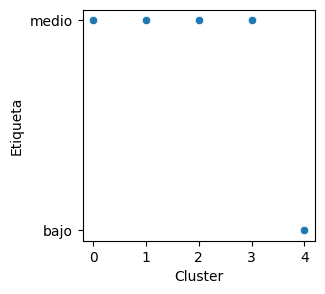

In [1391]:
plt.figure(figsize = (3, 3))
sns.scatterplot(data = lista_df_etiquetas_num[0], x = "Cluster", y = "Etiqueta")
plt.show()

## Activos

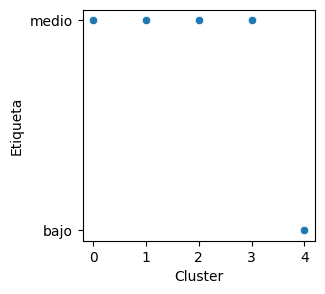

In [1392]:
plt.figure(figsize = (3, 3))
sns.scatterplot(data = lista_df_etiquetas_num[1], x = "Cluster", y = "Etiqueta")
plt.show()

## Pasivos

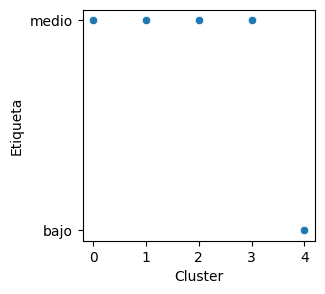

In [1393]:
plt.figure(figsize = (3, 3))
sns.scatterplot(data = lista_df_etiquetas_num[2], x = "Cluster", y = "Etiqueta")
plt.show()

## Portafolio_RentaFija

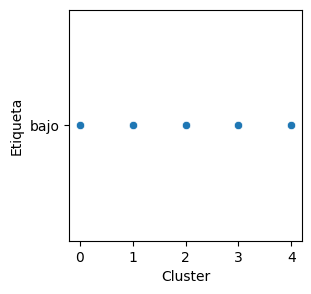

In [1394]:
plt.figure(figsize = (3, 3))
sns.scatterplot(data = lista_df_etiquetas_num[3], x = "Cluster", y = "Etiqueta")
plt.show()

## Portafolio_RentaVariable

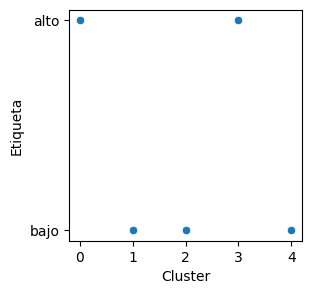

In [1395]:
plt.figure(figsize = (3, 3))
sns.scatterplot(data = lista_df_etiquetas_num[4], x = "Cluster", y = "Etiqueta")
plt.show()

## Entradas_Transaccionales

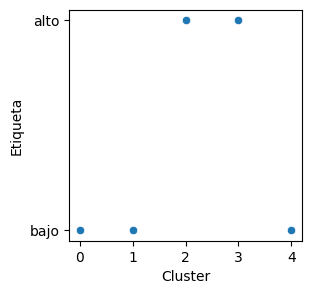

In [1396]:
plt.figure(figsize = (3, 3))
sns.scatterplot(data = lista_df_etiquetas_num[5], x = "Cluster", y = "Etiqueta")
plt.show()

## Salidas_Transaccionales

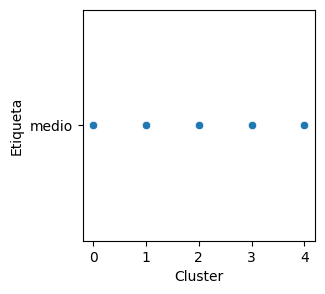

In [1397]:
plt.figure(figsize = (3, 3))
sns.scatterplot(data = lista_df_etiquetas_num[6], x = "Cluster", y = "Etiqueta")
plt.show()

## DivisasCompras

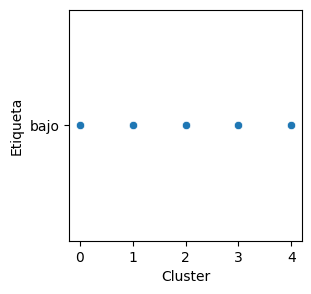

In [1398]:
plt.figure(figsize = (3, 3))
sns.scatterplot(data = lista_df_etiquetas_num[7], x = "Cluster", y = "Etiqueta")
plt.show()

## DivisasVentas

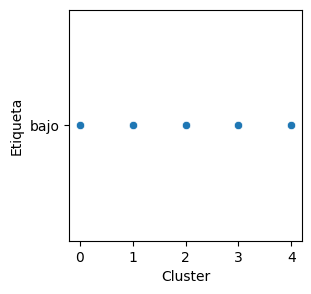

In [1399]:
plt.figure(figsize = (3, 3))
sns.scatterplot(data = lista_df_etiquetas_num[8], x = "Cluster", y = "Etiqueta")
plt.show()

### Ahora analicemos las variables categóricas. Para esto basta con calcular la cantidad de veces que se repita cada variable por cluster

In [1400]:
categoric_cols
lista_df_etiquetas_cat = []
for column in categoric_cols:
    profile = df_k_means.groupby("Cluster")[column].value_counts().unstack().fillna(0)
    lista_df_etiquetas_cat.append(profile)

## Tipo_ID

In [1401]:
lista_df_etiquetas_cat[0]

Tipo_ID,CC,CE,OT,PP,RC,TI
Cluster,,,,,,
0,"2,083.00",11.00,0.00,4.00,10.00,34.00
1,"2,127.00",37.00,1.00,2.00,6.00,31.00
2,"1,618.00",24.00,0.00,6.00,4.00,15.00
3,"1,316.00",10.00,1.00,7.00,0.00,12.00
4,787.00,13.00,0.00,4.00,4.00,22.00


## Ocupacion

In [1402]:
lista_df_etiquetas_cat[1]

Ocupacion,Ama de Casa,Empleado,Estudiante,Independiente,Otro,Pensionado,Rentista de Capital
Cluster,,,,,,,
0,72,655,102,300,172,330,511
1,61,794,106,342,106,224,571
2,26,740,54,254,64,130,399
3,29,583,33,240,49,97,315
4,42,157,67,101,68,142,253


## RangoEtario

In [1403]:
lista_df_etiquetas_cat[2]

RangoEtario,18-30,31-50,Mayor de 50,Menor de 18
Cluster,,,,
0,110,487,1529,16
1,132,559,1506,7
2,61,480,1119,7
3,54,487,803,2
4,72,144,606,8


## Estado

In [1404]:
lista_df_etiquetas_cat[3]

Estado,Activo,En Espera,Inactivo,Prospecto
Cluster,,,,
0,1443,439,223,37
1,1813,310,46,35
2,1590,24,16,37
3,1304,24,11,7
4,630,180,16,4


## NivelRiesgo

In [1405]:
lista_df_etiquetas_cat[4]

NivelRiesgo,Alto,Bajo,Medio
Cluster,,,
0,21,507,1614
1,33,545,1626
2,18,508,1141
3,6,389,951
4,18,86,726


## Segmento

In [1406]:
lista_df_etiquetas_cat[5]

Segmento,Corporativo,Personal
Cluster,,
0,6.00,"2,136.00"
1,1.00,"2,203.00"
2,1.00,"1,666.00"
3,3.00,"1,343.00"
4,0.00,830.00


## RiesgoOcupacion

In [1407]:
lista_df_etiquetas_cat[6]

RiesgoOcupacion,2,3,4,5
Cluster,,,,
0,985,511,346,300
1,1018,571,273,342
2,870,399,144,254
3,680,315,111,240
4,299,253,177,101


### Ahora, basados la totalidad de la información recolectada por el EDA y el modelo de segmentación de clientes en conjunto, crearemos el perfil de cada cluster
### Pero antes de esto, sacaremos unas conclusiones generales que aplican para todos los clusters
### La mayoría de clientes:
- Tienen una cantidad de activos y pasivos media, y de los activos, es bajo el número de los que se conoce de antemano el flujo de ingresos que generarán

- Tienen un cantidad de gastos media

- Manejan una compra y venta de divisas extranjeras baja

- Tienen cédula

- Son mayores de 50 años

- Utilizan los productos o servicios ofrecidos y mantienen una relación continua con la empresa. Además, son considerados valiosos, ya que generan ingresos recurrentes y pueden ser objeto de programas de fidelización

- Tienen una probabilidad promedio de cumplir con sus obligaciones financieras, además, tienen una ocupación poco riesgosa, y esto influye positivamente en su capacidad para cumplir con ellas a lo largo del tiempo

- Son individuos o consumidores finales que utilizan productos y servicios financieros para satisfacer sus necesidades personales

### Basados en el perfil general de los clientes, describamos el perfil específico de cada cluster:
- Cluster 0: Empledado con acciones y bajos ingresos

- Cluster 1: Empleado sin acciones y bajos ingresos

- Cluster 2: Empleado sin acciones y altos ingresos

- Cluster 3: Empleado con acciones y altos ingresos

- Cluster 4: Rentista de capital sin acciones y bajos ingresos

### Crearemos una tabla a parte con la descripción de cada cluster

In [1408]:
descripcion_cluster = {"Cluster" : [0, 1, 2 ,3 , 4],
                       "Descripcion" : ["Empleado con acciones y bajos ingresos",
                                        "Empleado sin acciones y bajos ingresos",
                                        "Empleado sin acciones y altos ingresos",
                                        "Empleado con acciones y altos ingresos",
                                        "Rentista de capital sin acciones y bajos ingresos"]}
descripcion_cluster = pd.DataFrame(descripcion_cluster)
descripcion_cluster

,Cluster,Descripcion
0,0,Empleado con acciones y bajos ingresos
1,1,Empleado sin acciones y bajos ingresos
2,2,Empleado sin acciones y altos ingresos
3,3,Empleado con acciones y altos ingresos
4,4,Rentista de capital sin acciones y bajos ingresos


### Por útltimo guardamos la tabla con los clientes y las transacciones, y la tabla con la descrpción de cada cluster, listas para ser interpretadas gráfica e interactivamente en Power BI

In [1409]:
df_k_means.to_csv("tabala_modelo_ML.csv", index = False)
descripcion_cluster.to_csv("tabla_descripcion_cluster.csv", index = False)